In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import matplotlib as plt
from datetime import datetime, timedelta
import re

In [17]:
train_data_fpath =  "training_dataset.parquet"
submission_data_fpath =  "submission_dataset.parquet"

In [18]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [19]:
input_df = pd.read_parquet(train_data_fpath)
test_df = pd.read_parquet(submission_data_fpath)
input_df.head(3)

,TimeStamp_StartFormat,wtc_AcWindSp_mean;1,wtc_AcWindSp_mean;2,wtc_AcWindSp_mean;3,wtc_AcWindSp_mean;4,wtc_AcWindSp_mean;5,wtc_AcWindSp_mean;7,wtc_AcWindSp_min;1,wtc_AcWindSp_min;2,wtc_AcWindSp_min;3,wtc_AcWindSp_min;4,wtc_AcWindSp_min;5,wtc_AcWindSp_min;7,wtc_AcWindSp_max;1,wtc_AcWindSp_max;2,wtc_AcWindSp_max;3,wtc_AcWindSp_max;4,wtc_AcWindSp_max;5,wtc_AcWindSp_max;7,wtc_AcWindSp_stddev;1,wtc_AcWindSp_stddev;2,wtc_AcWindSp_stddev;3,wtc_AcWindSp_stddev;4,wtc_AcWindSp_stddev;5,wtc_AcWindSp_stddev;7,wtc_ScYawPos_mean;1,wtc_ScYawPos_mean;2,wtc_ScYawPos_mean;3,wtc_ScYawPos_mean;4,wtc_ScYawPos_mean;5,wtc_ScYawPos_mean;7,wtc_ScYawPos_min;1,wtc_ScYawPos_min;2,wtc_ScYawPos_min;3,wtc_ScYawPos_min;4,wtc_ScYawPos_min;5,wtc_ScYawPos_min;7,wtc_ScYawPos_max;1,wtc_ScYawPos_max;2,wtc_ScYawPos_max;3,wtc_ScYawPos_max;4,wtc_ScYawPos_max;5,wtc_ScYawPos_max;7,wtc_ScYawPos_stddev;1,wtc_ScYawPos_stddev;2,wtc_ScYawPos_stddev;3,wtc_ScYawPos_stddev;4,wtc_ScYawPos_stddev;5,wtc_ScYawPos_stddev;7,wtc_NacelPos_mean;1,wtc_NacelPos_mean;2,wtc_NacelPos_mean;3,wtc_NacelPos_mean;4,wtc_NacelPos_mean;5,wtc_NacelPos_mean;7,wtc_NacelPos_min;1,wtc_NacelPos_min;2,wtc_NacelPos_min;3,wtc_NacelPos_min;4,wtc_NacelPos_min;5,wtc_NacelPos_min;7,wtc_NacelPos_max;1,wtc_NacelPos_max;2,wtc_NacelPos_max;3,wtc_NacelPos_max;4,wtc_NacelPos_max;5,wtc_NacelPos_max;7,wtc_GenRpm_mean;1,wtc_GenRpm_mean;2,wtc_GenRpm_mean;3,wtc_GenRpm_mean;4,wtc_GenRpm_mean;5,wtc_GenRpm_mean;7,wtc_GenRpm_min;1,wtc_GenRpm_min;2,wtc_GenRpm_min;3,wtc_GenRpm_min;4,wtc_GenRpm_min;5,wtc_GenRpm_min;7,wtc_GenRpm_max;1,wtc_GenRpm_max;2,wtc_GenRpm_max;3,wtc_GenRpm_max;4,wtc_GenRpm_max;5,wtc_GenRpm_max;7,wtc_GenRpm_stddev;1,wtc_GenRpm_stddev;2,wtc_GenRpm_stddev;3,wtc_GenRpm_stddev;4,wtc_GenRpm_stddev;5,wtc_GenRpm_stddev;7,wtc_PitcPosA_mean;1,wtc_PitcPosA_mean;2,wtc_PitcPosA_mean;3,wtc_PitcPosA_mean;4,wtc_PitcPosA_mean;5,wtc_PitcPosA_mean;7,wtc_PitcPosA_min;1,wtc_PitcPosA_min;2,wtc_PitcPosA_min;3,wtc_PitcPosA_min;4,wtc_PitcPosA_min;5,wtc_PitcPosA_min;7,wtc_PitcPosA_max;1,wtc_PitcPosA_max;2,wtc_PitcPosA_max;3,wtc_PitcPosA_max;4,wtc_PitcPosA_max;5,wtc_PitcPosA_max;7,wtc_PitcPosA_stddev;1,wtc_PitcPosA_stddev;2,wtc_PitcPosA_stddev;3,wtc_PitcPosA_stddev;4,wtc_PitcPosA_stddev;5,wtc_PitcPosA_stddev;7,wtc_PitcPosB_mean;1,wtc_PitcPosB_mean;2,wtc_PitcPosB_mean;3,wtc_PitcPosB_mean;4,wtc_PitcPosB_mean;5,wtc_PitcPosB_mean;7,wtc_PitcPosC_mean;1,wtc_PitcPosC_mean;2,wtc_PitcPosC_mean;3,wtc_PitcPosC_mean;4,wtc_PitcPosC_mean;5,wtc_PitcPosC_mean;7,wtc_PowerRef_endvalue;1,wtc_PowerRef_endvalue;2,wtc_PowerRef_endvalue;3,wtc_PowerRef_endvalue;4,wtc_PowerRef_endvalue;5,wtc_PowerRef_endvalue;7,wtc_ScReToOp_timeon;1,wtc_ScReToOp_timeon;2,wtc_ScReToOp_timeon;3,wtc_ScReToOp_timeon;4,wtc_ScReToOp_timeon;5,wtc_ScReToOp_timeon;7,wtc_ActPower_mean;1,wtc_ActPower_mean;2,wtc_ActPower_mean;3,wtc_ActPower_mean;4,wtc_ActPower_mean;5,wtc_ActPower_mean;7,wtc_ActPower_min;1,wtc_ActPower_min;2,wtc_ActPower_min;3,wtc_ActPower_min;4,wtc_ActPower_min;5,wtc_ActPower_min;7,wtc_ActPower_max;1,wtc_ActPower_max;2,wtc_ActPower_max;3,wtc_ActPower_max;4,wtc_ActPower_max;5,wtc_ActPower_max;7,wtc_ActPower_stddev;1,wtc_ActPower_stddev;2,wtc_ActPower_stddev;3,wtc_ActPower_stddev;4,wtc_ActPower_stddev;5,wtc_ActPower_stddev;7,wtc_AmbieTmp_mean;1,wtc_AmbieTmp_mean;2,wtc_AmbieTmp_mean;3,wtc_AmbieTmp_mean;4,wtc_AmbieTmp_mean;5,wtc_AmbieTmp_mean;7,ShutdownDuration;1,ShutdownDuration;2,ShutdownDuration;3,ShutdownDuration;4,ShutdownDuration;5,ShutdownDuration;7,ERA5_temperature_2m,ERA5_relative_humidity_2m,ERA5_dew_point_2m,ERA5_precipitation,ERA5_surface_pressure,ERA5_cloud_cover,ERA5_wind_speed_10m,ERA5_wind_speed_100m,ERA5_wind_direction_10m,ERA5_wind_direction_100m,ERA5_wind_gusts_10m,id,is_valid,target
0,2016-01-01 00:00:00,6.085917,5.830675,6.613091,6.998510,7.645727,7.040790,2.0,1.1,1.6,2.4,4.3,3.9,10.0,10.0,11.0,10.6,11.8,10.5,1.484347,1.586648,1.571053,1.228338,1.096910,1.317204,83.754387,69.120506,-122.800903,-113.638397,-118.159103,-106.894501,79.500000,66.400002,-124

In [20]:
len(input_df)

210384

In [21]:
input_df.columns

Index(['TimeStamp_StartFormat', 'wtc_AcWindSp_mean;1', 'wtc_AcWindSp_mean;2',
       'wtc_AcWindSp_mean;3', 'wtc_AcWindSp_mean;4', 'wtc_AcWindSp_mean;5',
       'wtc_AcWindSp_mean;7', 'wtc_AcWindSp_min;1', 'wtc_AcWindSp_min;2',
       'wtc_AcWindSp_min;3',
       ...
       'ERA5_surface_pressure', 'ERA5_cloud_cover', 'ERA5_wind_speed_10m',
       'ERA5_wind_speed_100m', 'ERA5_wind_direction_10m',
       'ERA5_wind_direction_100m', 'ERA5_wind_gusts_10m', 'id', 'is_valid',
       'target'],
      dtype='object', length=189)

In [22]:
input_df.head(3)

,TimeStamp_StartFormat,wtc_AcWindSp_mean;1,wtc_AcWindSp_mean;2,wtc_AcWindSp_mean;3,wtc_AcWindSp_mean;4,wtc_AcWindSp_mean;5,wtc_AcWindSp_mean;7,wtc_AcWindSp_min;1,wtc_AcWindSp_min;2,wtc_AcWindSp_min;3,wtc_AcWindSp_min;4,wtc_AcWindSp_min;5,wtc_AcWindSp_min;7,wtc_AcWindSp_max;1,wtc_AcWindSp_max;2,wtc_AcWindSp_max;3,wtc_AcWindSp_max;4,wtc_AcWindSp_max;5,wtc_AcWindSp_max;7,wtc_AcWindSp_stddev;1,wtc_AcWindSp_stddev;2,wtc_AcWindSp_stddev;3,wtc_AcWindSp_stddev;4,wtc_AcWindSp_stddev;5,wtc_AcWindSp_stddev;7,wtc_ScYawPos_mean;1,wtc_ScYawPos_mean;2,wtc_ScYawPos_mean;3,wtc_ScYawPos_mean;4,wtc_ScYawPos_mean;5,wtc_ScYawPos_mean;7,wtc_ScYawPos_min;1,wtc_ScYawPos_min;2,wtc_ScYawPos_min;3,wtc_ScYawPos_min;4,wtc_ScYawPos_min;5,wtc_ScYawPos_min;7,wtc_ScYawPos_max;1,wtc_ScYawPos_max;2,wtc_ScYawPos_max;3,wtc_ScYawPos_max;4,wtc_ScYawPos_max;5,wtc_ScYawPos_max;7,wtc_ScYawPos_stddev;1,wtc_ScYawPos_stddev;2,wtc_ScYawPos_stddev;3,wtc_ScYawPos_stddev;4,wtc_ScYawPos_stddev;5,wtc_ScYawPos_stddev;7,wtc_NacelPos_mean;1,wtc_NacelPos_mean;2,wtc_NacelPos_mean;3,wtc_NacelPos_mean;4,wtc_NacelPos_mean;5,wtc_NacelPos_mean;7,wtc_NacelPos_min;1,wtc_NacelPos_min;2,wtc_NacelPos_min;3,wtc_NacelPos_min;4,wtc_NacelPos_min;5,wtc_NacelPos_min;7,wtc_NacelPos_max;1,wtc_NacelPos_max;2,wtc_NacelPos_max;3,wtc_NacelPos_max;4,wtc_NacelPos_max;5,wtc_NacelPos_max;7,wtc_GenRpm_mean;1,wtc_GenRpm_mean;2,wtc_GenRpm_mean;3,wtc_GenRpm_mean;4,wtc_GenRpm_mean;5,wtc_GenRpm_mean;7,wtc_GenRpm_min;1,wtc_GenRpm_min;2,wtc_GenRpm_min;3,wtc_GenRpm_min;4,wtc_GenRpm_min;5,wtc_GenRpm_min;7,wtc_GenRpm_max;1,wtc_GenRpm_max;2,wtc_GenRpm_max;3,wtc_GenRpm_max;4,wtc_GenRpm_max;5,wtc_GenRpm_max;7,wtc_GenRpm_stddev;1,wtc_GenRpm_stddev;2,wtc_GenRpm_stddev;3,wtc_GenRpm_stddev;4,wtc_GenRpm_stddev;5,wtc_GenRpm_stddev;7,wtc_PitcPosA_mean;1,wtc_PitcPosA_mean;2,wtc_PitcPosA_mean;3,wtc_PitcPosA_mean;4,wtc_PitcPosA_mean;5,wtc_PitcPosA_mean;7,wtc_PitcPosA_min;1,wtc_PitcPosA_min;2,wtc_PitcPosA_min;3,wtc_PitcPosA_min;4,wtc_PitcPosA_min;5,wtc_PitcPosA_min;7,wtc_PitcPosA_max;1,wtc_PitcPosA_max;2,wtc_PitcPosA_max;3,wtc_PitcPosA_max;4,wtc_PitcPosA_max;5,wtc_PitcPosA_max;7,wtc_PitcPosA_stddev;1,wtc_PitcPosA_stddev;2,wtc_PitcPosA_stddev;3,wtc_PitcPosA_stddev;4,wtc_PitcPosA_stddev;5,wtc_PitcPosA_stddev;7,wtc_PitcPosB_mean;1,wtc_PitcPosB_mean;2,wtc_PitcPosB_mean;3,wtc_PitcPosB_mean;4,wtc_PitcPosB_mean;5,wtc_PitcPosB_mean;7,wtc_PitcPosC_mean;1,wtc_PitcPosC_mean;2,wtc_PitcPosC_mean;3,wtc_PitcPosC_mean;4,wtc_PitcPosC_mean;5,wtc_PitcPosC_mean;7,wtc_PowerRef_endvalue;1,wtc_PowerRef_endvalue;2,wtc_PowerRef_endvalue;3,wtc_PowerRef_endvalue;4,wtc_PowerRef_endvalue;5,wtc_PowerRef_endvalue;7,wtc_ScReToOp_timeon;1,wtc_ScReToOp_timeon;2,wtc_ScReToOp_timeon;3,wtc_ScReToOp_timeon;4,wtc_ScReToOp_timeon;5,wtc_ScReToOp_timeon;7,wtc_ActPower_mean;1,wtc_ActPower_mean;2,wtc_ActPower_mean;3,wtc_ActPower_mean;4,wtc_ActPower_mean;5,wtc_ActPower_mean;7,wtc_ActPower_min;1,wtc_ActPower_min;2,wtc_ActPower_min;3,wtc_ActPower_min;4,wtc_ActPower_min;5,wtc_ActPower_min;7,wtc_ActPower_max;1,wtc_ActPower_max;2,wtc_ActPower_max;3,wtc_ActPower_max;4,wtc_ActPower_max;5,wtc_ActPower_max;7,wtc_ActPower_stddev;1,wtc_ActPower_stddev;2,wtc_ActPower_stddev;3,wtc_ActPower_stddev;4,wtc_ActPower_stddev;5,wtc_ActPower_stddev;7,wtc_AmbieTmp_mean;1,wtc_AmbieTmp_mean;2,wtc_AmbieTmp_mean;3,wtc_AmbieTmp_mean;4,wtc_AmbieTmp_mean;5,wtc_AmbieTmp_mean;7,ShutdownDuration;1,ShutdownDuration;2,ShutdownDuration;3,ShutdownDuration;4,ShutdownDuration;5,ShutdownDuration;7,ERA5_temperature_2m,ERA5_relative_humidity_2m,ERA5_dew_point_2m,ERA5_precipitation,ERA5_surface_pressure,ERA5_cloud_cover,ERA5_wind_speed_10m,ERA5_wind_speed_100m,ERA5_wind_direction_10m,ERA5_wind_direction_100m,ERA5_wind_gusts_10m,id,is_valid,target
0,2016-01-01 00:00:00,6.085917,5.830675,6.613091,6.998510,7.645727,7.040790,2.0,1.1,1.6,2.4,4.3,3.9,10.0,10.0,11.0,10.6,11.8,10.5,1.484347,1.586648,1.571053,1.228338,1.096910,1.317204,83.754387,69.120506,-122.800903,-113.638397,-118.159103,-106.894501,79.500000,66.400002,-124

In [23]:
def rel_dir(df):
    for turbine_num in [2, 3, 4, 5, 7]:
        yaw_col = f'wtc_ScYawPos_mean;{turbine_num}'
        wind_dir_col = 'ERA5_wind_direction_10m'  # or 100m depending on your needs
        
        # Calculate relative angle
        df[f'relative_angle_{turbine_num}'] = (df[wind_dir_col] - df[yaw_col]).abs()
        
        # Normalize to [-180, 180]
        df[f'relative_angle_{turbine_num}'] = df[f'relative_angle_{turbine_num}'].apply(
            lambda x: x if x <= 180 else 360 - x
        )
    return df

In [24]:
def day_feature_adder(df):
    day_of_year = df['TimeStamp_StartFormat'].dt.dayofyear
    df['daylight_hours'] = 8 + 4 * np.sin(2 * np.pi * (day_of_year - 80) / 365.25)
    df['is_peak_wind'] = np.where(df['TimeStamp_StartFormat'].dt.month.isin([12, 1, 2]),1,0)



    df['minute_sin'] = np.sin(2 * np.pi * df['TimeStamp_StartFormat'].dt.minute / 60)
    df['minute_cos'] = np.cos(2 * np.pi * df['TimeStamp_StartFormat'].dt.minute / 60)

    df['hour_sin'] = np.sin(2 * np.pi * df['TimeStamp_StartFormat'].dt.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['TimeStamp_StartFormat'].dt.hour / 24)

    df['dayofyear_sin'] = np.sin(2 * np.pi * df['TimeStamp_StartFormat'].dt.dayofyear / 365)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df['TimeStamp_StartFormat'].dt.dayofyear / 365)

    df['month_sin'] = np.sin(2 * np.pi * df['TimeStamp_StartFormat'].dt.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['TimeStamp_StartFormat'].dt.month / 12)
    return df

In [25]:
def add_lagged_wind_speeds(df, timestamp_col='TimeStamp_StartFormat', turbine_prefix=';'):
    """
    Add lagged wind speed features for each turbine (15min and 1hr lags)
    
    Args:
        df (pd.DataFrame): Must contain:
            - timestamp_col: DateTime column
            - f'Wind_speed_{turbine_prefix}N' for each turbine
        turbine_prefix (str): Prefix used in turbine column names
        
    Returns:
        pd.DataFrame: Original df + new lagged wind speed columns
    """
    # Make sure we're working with a copy
    df = df.copy()
    
    # Sort by time to ensure proper shifting
    df = df.sort_values(timestamp_col).reset_index(drop=True)
    
    # Time deltas for lags
    lag_30min = timedelta(minutes=10)
    lag_1hr = timedelta(minutes=60)
    
    for turbine_num in [2,3,4,5,7]:  # For turbines 2,3,4,5,7 (6 being predicted)
        wind_col = f'wtc_ActPower_mean{turbine_prefix}{turbine_num}'
        
        # Create temporary DataFrame for merging
        lagged = df[[timestamp_col, wind_col]].copy()
        
        # Calculate 30min lag
        lagged['temp_30min'] = lagged[timestamp_col] + lag_30min
        lagged = lagged.rename(columns={wind_col: f'{wind_col}_lag30min'})
        df = pd.merge_asof(
            df.sort_values(timestamp_col),
            lagged[['temp_30min', f'{wind_col}_lag30min']].sort_values('temp_30min'),
            left_on=timestamp_col,
            right_on='temp_30min',
            direction='backward'
        ).drop(columns='temp_30min')
        
        # Calculate 1hr lag
        lagged['temp_1hr'] = lagged[timestamp_col] + lag_1hr
        lagged = lagged.rename(columns={f'{wind_col}_lag30min': f'{wind_col}_lag1hr'})
        df = pd.merge_asof(
            df.sort_values(timestamp_col),
            lagged[['temp_1hr', f'{wind_col}_lag1hr']].sort_values('temp_1hr'),
            left_on=timestamp_col,
            right_on='temp_1hr',
            direction='backward'
        ).drop(columns='temp_1hr')
    
    return df

In [26]:
def add_lagged_act_power(df, timestamp_col='TimeStamp_StartFormat', 
                         lags=[(10, '10min'),(30, '30min')], 
                         turbine_prefix=';'):
    """
    Add lagged active power features for each turbine
    
    Args:
        df (pd.DataFrame): Must contain:
            - timestamp_col: DateTime column
            - Columns containing 'ActPower' in their names
        lags (list of tuples): List of (minutes, suffix_name) for each lag
        turbine_prefix (str): Prefix used in turbine column names
        
    Returns:
        pd.DataFrame: Original df + new lagged active power columns
    """
    # Make sure we're working with a copy
    df = df.copy()
    
    # Sort by time to ensure proper shifting
    df = df.sort_values(timestamp_col).reset_index(drop=True)
    
    # Find all ActPower columns
    act_power_cols = [col for col in df.columns if 'wtc_Ac' in col]#'ActPower'
    
    for act_power_col in act_power_cols:
        for minutes, suffix in lags:
            # Create temporary DataFrame for merging
            lagged = df[[timestamp_col, act_power_col]].copy()
            lag_delta = timedelta(minutes=minutes)
            
            # Calculate lag
            lagged['temp_time'] = lagged[timestamp_col] + lag_delta
            lagged = lagged.rename(columns={act_power_col: f'{act_power_col}_lag{suffix}'})
            
            df = pd.merge_asof(
                df.sort_values(timestamp_col),
                lagged[['temp_time', f'{act_power_col}_lag{suffix}']].sort_values('temp_time'),
                left_on=timestamp_col,
                right_on='temp_time',
                direction='backward'
            ).drop(columns='temp_time')
    
    return df

In [27]:
def add_trig_transforms(df, substrings=('Pos', 'direction'), radians=True):
    """
    Adds sin and cos transformations for columns containing any of the specified substrings.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame
    substrings : tuple of str (default=('Pos', 'direction'))
        Substrings to identify columns to transform
    radians : bool (default=True)
        If False, converts values from degrees to radians first
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with new sin/cos columns added
    """
    df_transformed = df.copy()
    
    for col in df.columns:
        if any(sub in col for sub in substrings):
            values = df[col]
            
            if not radians:
                values = np.radians(values)
                
            df_transformed[f'{col}_sin'] = np.sin(values)
            df_transformed[f'{col}_cos'] = np.cos(values)
    
    return df_transformed

In [28]:
input_df= input_df[~input_df.target.isna()]

In [29]:
#pattern = re.compile(r'max|min')#max|min
#test_df = test_df.loc[:, ~test_df.columns.str.contains(pattern)]

In [30]:
input_df = rel_dir(input_df)
test_df= rel_dir(test_df)

In [31]:
input_df = add_lagged_act_power(input_df)
test_df= add_lagged_act_power(test_df)

In [ ]:
#input_df = add_lagged_wind_speeds(input_df)
#test_df= add_lagged_wind_speeds(test_df)

In [ ]:
input_df = day_feature_adder(input_df)
test_df= day_feature_adder(test_df)

In [ ]:
input_df = add_trig_transforms(input_df)
test_df= add_trig_transforms(test_df)

In [35]:
y = input_df["target"]


In [36]:
#import re
#pattern = re.compile(r'max|min')#max|min
#test_df = test_df.loc[:, ~test_df.columns.str.contains(pattern)]

In [37]:

X_raw = input_df[test_df.columns].fillna(0).drop(["TimeStamp_StartFormat"],axis=1)
scaler = StandardScaler()
model = scaler.fit(X_raw)
X_scaled = model.transform(X_raw)

test_raw = test_df.fillna(0).drop(["TimeStamp_StartFormat"],axis=1)
#scaler = StandardScaler()
X_test = model.transform(test_raw)

In [38]:
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.25, random_state=123
)

In [39]:
xgb_model = xgb.XGBRegressor(
    objective='reg:absoluteerror',#absoluteerror#squarederror
    n_estimators=500,
    learning_rate=0.05,
    max_depth=10
    ,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1
)

# Train the model
xgb_model.fit(
    X_train, 
    y_train,
    eval_set=[(X_val, y_val)],
    
    verbose=True
)

# Evaluate on validation set
val_pred = xgb_model.predict(X_val)
val_mae = mean_absolute_error(y_val, val_pred)
print(f"Validation MAE: {val_mae:.4f}")


# Make predictions
test_pred = xgb_model.predict(X_test)

# Save predictions
np.savetxt("predictions_xgboost.csv", test_pred, delimiter=",")

[0]	validation_0-mae:520.54654
[1]	validation_0-mae:495.76278
[2]	validation_0-mae:472.01281
[3]	validation_0-mae:450.29872
[4]	validation_0-mae:428.49982
[5]	validation_0-mae:408.98881
[6]	validation_0-mae:388.95446
[7]	validation_0-mae:370.81893
[8]	validation_0-mae:352.70179
[9]	validation_0-mae:336.41878
[10]	validation_0-mae:320.08645
[11]	validation_0-mae:304.39315
[12]	validation_0-mae:290.72745
[13]	validation_0-mae:276.68326
[14]	validation_0-mae:263.47514
[15]	validation_0-mae:251.01220
[16]	validation_0-mae:239.20166
[17]	validation_0-mae:228.15070
[18]	validation_0-mae:217.72361
[19]	validation_0-mae:208.00528
[20]	validation_0-mae:198.83827
[21]	validation_0-mae:190.25419
[22]	validation_0-mae:182.30546
[23]	validation_0-mae:174.69878
[24]	validation_0-mae:167.63598
[25]	validation_0-mae:161.02366
[26]	validation_0-mae:154.69286
[27]	validation_0-mae:148.83459
[28]	validation_0-mae:143.35084
[29]	validation_0-mae:138.25541
[30]	validation_0-mae:133.49528
[31]	validation_0-

In [40]:
#best 50.35 depth 12

In [43]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization

# 1. Create sequences first (assuming X_scaled and y are your preprocessed data)
def create_sequences(data, targets, window_size=6):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(targets[i+window_size])
    return np.array(X), np.array(y)

# Create sequences with 24-time-step windows
X_sequences, y_sequences = create_sequences(X_raw, y, window_size=24)

# 2. Split into train/validation AFTER sequencing
X_train, X_val, y_train, y_val = train_test_split(
    X_sequences, 
    y_sequences, 
    test_size=0.25, 
    random_state=123,
    shuffle=False  # Important for time series!
)

# 3. Verify shapes
print(f"Train shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Validation shapes: X={X_val.shape}, y={y_val.shape}")

# 4. Build CNN-LSTM model
model = Sequential([
    # Temporal convolution
    Conv1D(filters=64, kernel_size=3, activation='relu', 
           input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    
    # Sequence processing
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    
    # Output
    Dense(1)
])

model.compile(optimizer='adam', loss='mae')

# 5. Train with validation
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    verbose=1
)

# 6. Evaluate
val_loss = model.evaluate(X_val, y_val, verbose=0)
print(f"\nFinal Validation MAE: {val_loss:.4f}")

Train shapes: X=(155925, 24, 243), y=(155925,)
Validation shapes: X=(51975, 24, 243), y=(51975,)
Epoch 1/50
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 78s 30ms/step - loss: 610.4190 - val_loss: 517.4731
Epoch 2/50
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 61s 25ms/step - loss: 518.5172 - val_loss: 447.0045
Epoch 3/50
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 65s 27ms/step - loss: 456.0977 - val_loss: 388.6454
Epoch 4/50
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 78s 32ms/step - loss: 396.8585 - val_loss: 339.6629
Epoch 5/50
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 75s 31ms/step - loss: 349.6780 - val_loss: 300.2867
Epoch 6/50
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 70s 29ms/step - loss: 310.0596 - val_loss: 265.8917
Epoch 7/50
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 73s 30ms/step - loss: 273.6431 - val_loss: 238.8751
Epoch 8/50
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 72s 30ms/step - loss: 246.6111 - val_loss: 214.3689
Epoch 9/50
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 74s 30ms/step - loss: 220.6341 - val_loss: 193.0771
Epoch 10/50
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 73s 30ms/step 

KeyboardInterrupt: 

c:\Users\conny\OneDrive\Documents\Projects\wind_towie\kaggle_hill_of_towie\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:20:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "feature_names" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AttributeError: module 'matplotlib' has no attribute 'show'

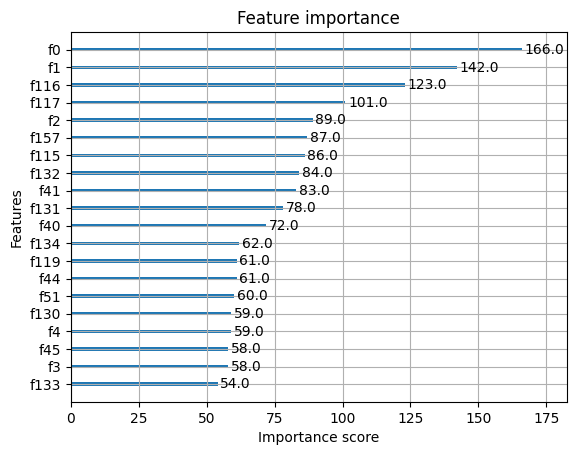

In [ ]:

# Train basic model
model = xgb.XGBRegressor().fit(X_train, y_train)

# Visualize feature importance
xgb.plot_importance(model, max_num_features=20)
plt.show()

In [ ]:
from sklearn.feature_selection import mutual_info_regression

def evaluate_features(X, y):
    """Calculate mutual information scores"""
    mi_scores = mutual_info_regression(X, y)
    return pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Usage:
mi_scores = evaluate_features(X_train, y_train)
print(mi_scores.head(20)) 

KeyboardInterrupt: 